<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/link-prediction/node2vec-link-prediction.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/node2vec-link-prediction.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

In [1]:
import matplotlib.pyplot as plt
from math import isclose
from sklearn.decomposition import PCA
import os
import stellargraph as sg

import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter
from collections import Counter
import multiprocessing
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses, metrics, Model, regularizers
from sklearn import preprocessing, feature_extraction, model_selection
from copy import deepcopy
import matplotlib.pyplot as plt
from stellargraph import datasets
from IPython.display import display, HTML
import dill
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import math
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from copy import deepcopy
import torch
from scipy.sparse import identity
import numpy as np
import logging

import plotly.graph_objects as go
import numpy as np
import pandas as pd 
import os
from sklearn.metrics import precision_recall_curve
from collections import Counter
# from tqdm import tqdm_notebook as tqdm
# tqdm().pandas()
import json
import pickle
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.model_selection import StratifiedKFold
from keras.models import load_model
from sklearn.metrics import log_loss
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
import tensorflow as tf
import random
from matplotlib import pyplot as plt
import seaborn as sns
import os
import umap
from sklearn.cluster import KMeans
from keras import backend as K
from sklearn.manifold import TSNE
from IPython.core.display import display, HTML
from sklearn.preprocessing import StandardScaler, MinMaxScaler
display(HTML("<style>.container { width:80% !important; }</style>"))
from plotly.offline import init_notebook_mode, iplot
from sklearn.decomposition import PCA
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding


from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline




Bad key "text.kerning_factor" on line 4 in
/Users/chaupham/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


## Load the dataset

The Cora dataset is a homogeneous network where all nodes are papers and edges between nodes are citation links, e.g. paper A cites paper B.

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [ ]:
path = "../my_data/"

In [2]:
features_df = pd.read_csv(path + "cancer_mice_data.csv")
features_df.head()

,chr,start,end,strand,symbol,length,P53KO-O1,p53KO-O2,p53KO-O-CAS1,p53KO-O-CAS2,...,FDR,RAS/WT-O-L2FC,PValue.1,FDR.1,53KO/WT-Lg2FCh,PValue.2,FDR.2,CASvWT-Lg2FCh,PValue.3,FDR.3
0,chr8,68141938.0,68995536.0,+,41699,4832.0,585.0,1034.0,806.0,746.0,...,7.613703e-01,3.36,7.350000e-18,9.290000e-16,3.551469,4.090000e-26,3.240000e-24,3.134750,6.110000e-20,6.460000e-19
1,chr17,33822636.0,33855622.0,-,41700,3972.0,2631.0,3108.0,2833.0,2821.0,...,3.463080e-04,-0.21,6.013309e-01,1.000000e+00,-0.219320,2.086368e-01,4.064648e-01,-0.993011,9.940000e-06,3.370000e-05
2,chr18,56921369.0,57085202.0,-,41701,1759.0,6.0,26.0,34.0,24.0,...,7.737728e-01,-0.86,5.345735e-02,2.123310e-01,-2.349920,2.684855e-03,9.652530e-03,-0.766251,1.051426e-02,2.334048e-02
3,chr1,72473685.0,72583138.0,-,41702,4191.0,0.0,0.0,6.0,2.0,...,6.157249e-02,0.00,1.000000e+00,1.000000e+00,0.000000,1.000000e+00,1.000000e+00,1.979800,6.369788e-02,1.209788e-01
4,chr19,37282034.0,37298947.0,+,41703,5292.0,4778.0,4921.0,4569.0,4307.0,...,2.576700e-07,0.47,1.703489e-02,8.977116e-02,0.322160,5.467157e-01,8.592461e-01,-0.622518,1.740115e-03,4.395205e-03


In [3]:
avg_cols = ['P53KO-O1', 'p53KO-O2', 'p53KO-O-CAS1', 'p53KO-O-CAS2', 'p53KO-O-RAS1', 'p53KO-O-RAS2', 'WT-O1', 'WT-O2']


    
features_df = features_df[avg_cols + ['symbol']]



In [4]:
feature_cols = avg_cols
len(feature_cols)

8

In [5]:
features_df.symbol

0         41699
1         41700
2         41701
3         41702
4         41703
          ...  
19310    Zyg11b
19311       Zyx
19312     Zzef1
19313      Zzz3
19314       NaN
Name: symbol, Length: 19315, dtype: object

In [6]:
df=pd.read_csv(path + "PathwayCommons.sif", sep="\t", header=None)
df.columns = ["gene1", "connection", "gene2"]

df  = df[["gene1", "gene2", "connection"]]
df.columns = ["source", "target", "weight"]
df["weight"] = 1
df.head()

,source,target,weight
0,GNGT2,GNGT1,1
1,CFL1,SERPINH1,1
2,CFL2,CFL1,1
3,OR10J5,GNGT1,1
4,LUZP4,CFL2,1


In [7]:
df.source = df.source.apply(lambda x: str(x).lower())
df.target = df.target.apply(lambda x: str(x).lower())

In [8]:
features_df = features_df.drop_duplicates(subset= ["symbol"]).dropna(subset=["symbol"])

features_df.symbol = features_df.symbol.apply(lambda x: str(x).lower())
features_df.symbol

0         41699
1         41700
2         41701
3         41702
4         41703
          ...  
19309    zyg11a
19310    zyg11b
19311       zyx
19312     zzef1
19313      zzz3
Name: symbol, Length: 19312, dtype: object

In [9]:
print(len(set(features_df.symbol)))
print(len(set.intersection(set(features_df.symbol), set(df.source))))
print(len(set.intersection(set(features_df.symbol), set(df.target))))


overlapping_genes = set.intersection(set(features_df.symbol), set.union(set(df.target),  set(df.source) )) 
print(len(overlapping_genes))

19312
13389
13892
14318


In [10]:
all_genes = set.union(set(df.target), set(df.source))
print(len(overlapping_genes))
gene_df = pd.DataFrame({"gene":list(overlapping_genes)})
gene_df = pd.merge(gene_df, features_df, left_on="gene", right_on="symbol", how="left")
print(gene_df.shape)
gene_df = gene_df.drop(columns=["symbol"])
gene_df = gene_df.fillna(0)

14318
(14318, 10)


In [11]:
gene_df

,gene,P53KO-O1,p53KO-O2,p53KO-O-CAS1,p53KO-O-CAS2,p53KO-O-RAS1,p53KO-O-RAS2,WT-O1,WT-O2
0,slc10a6,2.0,10.0,141.0,127.0,27.0,2.0,0.0,2.0
1,lpar2,48.0,71.0,149.0,116.0,140.0,62.0,105.0,93.0
2,hist1h4b,128.0,81.0,243.0,184.0,33.0,32.0,41.0,29.0
3,iqgap2,6404.0,9405.0,7459.0,7535.0,22639.0,17707.0,13331.0,15431.0
4,atxn7,1042.0,1831.0,1929.0,1298.0,2422.0,1333.0,648.0,840.0
...,...,...,...,...,...,...,...,...,...
14313,mxd3,522.0,369.0,1224.0,1148.0,1100.0,774.0,397.0,277.0
14314,cldn2,1668.0,2854.0,1604.0,1406.0,7518.0,5416.0,4777.0,3223.0
14315,ccdc92,42.0,42.0,97.0,91.0,40.0,19.0,12.0,6.0
14316,wnt16,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
avg_cols[0]

'P53KO-O1'

In [13]:
from scipy.stats import zscore
for c in gene_df.columns:
    if c == "gene":
        pass
    else:
        gene_df[c] = zscore(gene_df[c])

In [14]:
gene_df.head()

,gene,P53KO-O1,p53KO-O2,p53KO-O-CAS1,p53KO-O-CAS2,p53KO-O-RAS1,p53KO-O-RAS2,WT-O1,WT-O2
0,slc10a6,-0.107076,-0.122684,-0.123576,-0.118272,-0.070109,-0.066066,-0.066156,-0.058017
1,lpar2,-0.105101,-0.119758,-0.123233,-0.118749,-0.068810,-0.065157,-0.063765,-0.056186
2,hist1h4b,-0.101666,-0.119278,-0.119199,-0.115796,-0.070040,-0.065611,-0.065222,-0.057474
3,iqgap2,0.167789,0.328007,0.190426,0.203445,0.189866,0.202193,0.237457,0.252418
4,atxn7,-0.062424,-0.035328,-0.046856,-0.067417,-0.042573,-0.045899,-0.051398,-0.041156


In [15]:
df= df[df.source.isin(overlapping_genes)]
df = df[df.target.isin(overlapping_genes)]

In [16]:
graph = StellarGraph( nodes={"gene": gene_df.set_index("gene") }, edges={"interact": df})
print("Done!")
print(graph.info())


Done!
StellarGraph: Undirected multigraph
 Nodes: 14318, Edges: 657433

 Node types:
  gene: [14318]
    Features: float32 vector, length 8
    Edge types: gene-interact->gene

 Edge types:
    gene-interact->gene: [657433]
        Weights: all 1 (default)
        Features: none


In [17]:
#### Write
import dill
with open('/Users/chaupham/Downloads/gene_and_nodefeatures.pkl', 'wb') as f:     
    dill.dump(graph, f)

## Construct splits of the input data

We have to carefully split the data to avoid data leakage and evaluate the algorithms correctly:

* For computing node embeddings, a **Train Graph** (`graph_train`)
* For training classifiers, a classifier **Training Set** (`examples_train`) of positive and negative edges that weren't used for computing node embeddings
* For choosing the best classifier, an **Model Selection Test Set** (`examples_model_selection`) of positive and negative edges that weren't used for computing node embeddings or training the classifier 
* For the final evaluation, a **Test Graph** (`graph_test`) to compute test node embeddings with more edges than the Train Graph, and a **Test Set** (`examples_test`) of positive and negative edges not used for neither computing the test node embeddings or for classifier training or model selection

###  Test Graph

We begin with the full graph and use the `EdgeSplitter` class to produce:

* Test Graph
* Test set of positive/negative link examples

The Test Graph is the reduced graph we obtain from removing the test set of links from the full graph.

In [18]:
G=graph

In [19]:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True, seed=2021
)


** Sampled 65743 positive and 65743 negative edges. **


### Train Graph

This time, we use the `EdgeSplitter` on the Test Graph, and perform a train/test split on the examples to produce:

* Train Graph
* Training set of link examples
* Set of link examples for model selection


In [20]:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True, seed=2021
)

** Sampled 59169 positive and 59169 negative edges. **


In [21]:
edge_labels_train

array([1, 1, 1, ..., 0, 0, 0])

In [22]:
edge_ids_train

array([['tcp1', 'numa1'],
       ['ccnk', 'itgb1bp2'],
       ['mtss1l', 'sf1'],
       ...,
       ['stoml1', 'eif4a1'],
       ['ccdc97', 'lmcd1'],
       ['flg2', 'traf3']], dtype=object)

In [23]:
print(G.info())


StellarGraph: Undirected multigraph
 Nodes: 14318, Edges: 657433

 Node types:
  gene: [14318]
    Features: float32 vector, length 8
    Edge types: gene-interact->gene

 Edge types:
    gene-interact->gene: [657433]
        Weights: all 1 (default)
        Features: none


In [24]:
print(G_test.info())


StellarGraph: Undirected multigraph
 Nodes: 14318, Edges: 591690

 Node types:
  gene: [14318]
    Features: float32 vector, length 8
    Edge types: gene-interact->gene

 Edge types:
    gene-interact->gene: [591690]
        Weights: all 1 (default)
        Features: none


In [25]:
print(G_train.info())


StellarGraph: Undirected multigraph
 Nodes: 14318, Edges: 532521

 Node types:
  gene: [14318]
    Features: float32 vector, length 8
    Edge types: gene-interact->gene

 Edge types:
    gene-interact->gene: [532521]
        Weights: all 1 (default)
        Features: none


Below is a summary of the different splits that have been created in this section

In [36]:
epochs = 250
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

gcn = GCN(
    layer_sizes=[20, 10, 5], activations=["relu", "relu","softmax"], generator=train_gen, dropout=0.10)
x_inp, x_out = gcn.in_out_tensors()

prediction = LinkEmbedding(activation="relu", method="ip")(x_out)
prediction = keras.layers.Reshape((-1,))(prediction)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0005),
    loss=keras.losses.binary_crossentropy,
    metrics=["binary_accuracy", "AUC"],
)

init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))
    
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
)

Using GCN (local pooling) filters...
Using GCN (local pooling) filters...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
1/1 [==============================] - 0s 907us/step - loss: 0.9158 - binary_accuracy: 0.5000 - auc: 0.5099

Train Set Metrics of the initial (untrained) model:
	loss: 0.9157
	binary_accuracy: 0.5000
	auc: 0.5102

Test Set Metrics of the initial (untrained) model:
	loss: 0.9158
	binary_accuracy: 0.5000
	auc: 0.5099
Epoch 1/250
1/1 - 0s - loss: 0.9157 - binary_accuracy: 0.5000 - auc: 0.5124 - val_loss: 0.9157 - val_binary_accuracy: 0.5000 - val_auc: 0.5122
Epoch 2/250
1/1 - 0s - loss: 0.9158 - binary_accuracy: 0.5000 - auc: 0.5072 - val_loss: 0.9156 - val_binary_accuracy: 0.5000 - val_auc: 0.5152
Epoch 3/250
1/1 - 0s - loss: 0.9154 - binary_accuracy: 0.5000 - auc: 0.5282 - val_loss: 0.9155 - val_binary_accuracy: 0.5000 - val_auc: 0.5185
Epoch 4/250
1/1 - 0s - loss: 0.9153 - binary_accuracy: 0.5000 - auc: 0.5314 - val_loss: 0.9154 - va

Epoch 52/250
1/1 - 0s - loss: 0.8920 - binary_accuracy: 0.5000 - auc: 0.8343 - val_loss: 0.8897 - val_binary_accuracy: 0.5000 - val_auc: 0.8425
Epoch 53/250
1/1 - 0s - loss: 0.8913 - binary_accuracy: 0.5000 - auc: 0.8362 - val_loss: 0.8886 - val_binary_accuracy: 0.5000 - val_auc: 0.8479
Epoch 54/250
1/1 - 0s - loss: 0.8879 - binary_accuracy: 0.5000 - auc: 0.8491 - val_loss: 0.8875 - val_binary_accuracy: 0.5000 - val_auc: 0.8531
Epoch 55/250
1/1 - 0s - loss: 0.8873 - binary_accuracy: 0.5000 - auc: 0.8512 - val_loss: 0.8863 - val_binary_accuracy: 0.5000 - val_auc: 0.8566
Epoch 56/250
1/1 - 0s - loss: 0.8860 - binary_accuracy: 0.5000 - auc: 0.8556 - val_loss: 0.8851 - val_binary_accuracy: 0.5000 - val_auc: 0.8595
Epoch 57/250
1/1 - 0s - loss: 0.8843 - binary_accuracy: 0.5000 - auc: 0.8587 - val_loss: 0.8839 - val_binary_accuracy: 0.5000 - val_auc: 0.8624
Epoch 58/250
1/1 - 0s - loss: 0.8832 - binary_accuracy: 0.5000 - auc: 0.8616 - val_loss: 0.8827 - val_binary_accuracy: 0.5000 - val_auc:

Epoch 109/250
1/1 - 0s - loss: 0.8040 - binary_accuracy: 0.5000 - auc: 0.8871 - val_loss: 0.8037 - val_binary_accuracy: 0.5000 - val_auc: 0.8885
Epoch 110/250
1/1 - 0s - loss: 0.8025 - binary_accuracy: 0.5000 - auc: 0.8872 - val_loss: 0.8022 - val_binary_accuracy: 0.5000 - val_auc: 0.8884
Epoch 111/250
1/1 - 0s - loss: 0.8010 - binary_accuracy: 0.5000 - auc: 0.8871 - val_loss: 0.8006 - val_binary_accuracy: 0.5000 - val_auc: 0.8884
Epoch 112/250
1/1 - 1s - loss: 0.8007 - binary_accuracy: 0.5000 - auc: 0.8877 - val_loss: 0.7990 - val_binary_accuracy: 0.5000 - val_auc: 0.8885
Epoch 113/250
1/1 - 0s - loss: 0.7998 - binary_accuracy: 0.5000 - auc: 0.8882 - val_loss: 0.7975 - val_binary_accuracy: 0.5000 - val_auc: 0.8886
Epoch 114/250
1/1 - 1s - loss: 0.8005 - binary_accuracy: 0.5000 - auc: 0.8885 - val_loss: 0.7959 - val_binary_accuracy: 0.5000 - val_auc: 0.8886
Epoch 115/250
1/1 - 0s - loss: 0.7939 - binary_accuracy: 0.5000 - auc: 0.8876 - val_loss: 0.7943 - val_binary_accuracy: 0.5000 - v

Epoch 166/250
1/1 - 0s - loss: 0.6317 - binary_accuracy: 0.5725 - auc: 0.8895 - val_loss: 0.6228 - val_binary_accuracy: 0.5868 - val_auc: 0.8894
Epoch 167/250
1/1 - 0s - loss: 0.6260 - binary_accuracy: 0.5814 - auc: 0.8893 - val_loss: 0.6187 - val_binary_accuracy: 0.5936 - val_auc: 0.8893
Epoch 168/250
1/1 - 0s - loss: 0.6296 - binary_accuracy: 0.5759 - auc: 0.8896 - val_loss: 0.6147 - val_binary_accuracy: 0.6007 - val_auc: 0.8893
Epoch 169/250
1/1 - 0s - loss: 0.6178 - binary_accuracy: 0.5956 - auc: 0.8893 - val_loss: 0.6107 - val_binary_accuracy: 0.6081 - val_auc: 0.8893
Epoch 170/250
1/1 - 1s - loss: 0.6110 - binary_accuracy: 0.6083 - auc: 0.8885 - val_loss: 0.6068 - val_binary_accuracy: 0.6149 - val_auc: 0.8892
Epoch 171/250
1/1 - 0s - loss: 0.6114 - binary_accuracy: 0.6073 - auc: 0.8891 - val_loss: 0.6030 - val_binary_accuracy: 0.6224 - val_auc: 0.8892
Epoch 172/250
1/1 - 0s - loss: 0.6022 - binary_accuracy: 0.6243 - auc: 0.8880 - val_loss: 0.5992 - val_binary_accuracy: 0.6295 - v

Epoch 223/250
1/1 - 0s - loss: 0.5125 - binary_accuracy: 0.8071 - auc: 0.8852 - val_loss: 0.5109 - val_binary_accuracy: 0.8076 - val_auc: 0.8863
Epoch 224/250
1/1 - 0s - loss: 0.5124 - binary_accuracy: 0.8062 - auc: 0.8852 - val_loss: 0.5107 - val_binary_accuracy: 0.8076 - val_auc: 0.8862
Epoch 225/250
1/1 - 1s - loss: 0.5123 - binary_accuracy: 0.8077 - auc: 0.8860 - val_loss: 0.5104 - val_binary_accuracy: 0.8074 - val_auc: 0.8862
Epoch 226/250
1/1 - 1s - loss: 0.5117 - binary_accuracy: 0.8059 - auc: 0.8851 - val_loss: 0.5102 - val_binary_accuracy: 0.8072 - val_auc: 0.8861
Epoch 227/250
1/1 - 0s - loss: 0.5123 - binary_accuracy: 0.8076 - auc: 0.8859 - val_loss: 0.5100 - val_binary_accuracy: 0.8072 - val_auc: 0.8861
Epoch 228/250
1/1 - 0s - loss: 0.5119 - binary_accuracy: 0.8074 - auc: 0.8860 - val_loss: 0.5098 - val_binary_accuracy: 0.8070 - val_auc: 0.8860
Epoch 229/250
1/1 - 1s - loss: 0.5109 - binary_accuracy: 0.8052 - auc: 0.8850 - val_loss: 0.5097 - val_binary_accuracy: 0.8069 - v

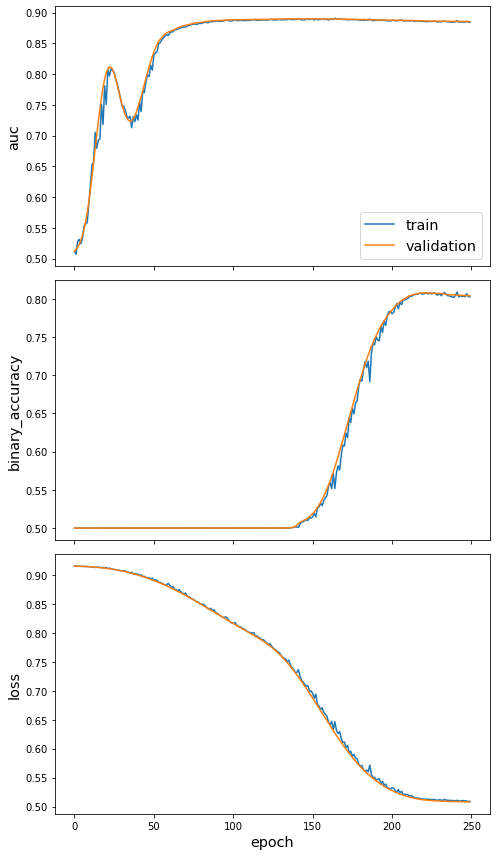

In [37]:
sg.utils.plot_history(history)


In [38]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 981us/step - loss: 0.5078 - binary_accuracy: 0.8040 - auc: 0.8853

Train Set Metrics of the trained model:
	loss: 0.5093
	binary_accuracy: 0.8035
	auc: 0.8850

Test Set Metrics of the trained model:
	loss: 0.5078
	binary_accuracy: 0.8040
	auc: 0.8853


In [29]:
test_metrics


[0.5065717697143555, 0.8099417686462402]

In [30]:
res_pred = model.predict(test_flow)
tmp = pd.DataFrame({"src": [e[0] for e in edge_ids_test], "des": [e[1] for e in edge_ids_test], "pred_prob": res_pred[0],  "pred_label": (res_pred[0]>0.5).astype(int), "true_label": edge_labels_test})
tmp["is_correct"]= tmp["pred_label"] == tmp["true_label"]
tmp.head()


,src,des,pred_prob,pred_label,true_label,is_correct
0,inpp5d,fnbp1,0.700865,1,1,True
1,rac1,efna1,0.740308,1,1,True
2,fen1,foxp3,0.630071,1,1,True
3,smarce1,krt31,0.820687,1,1,True
4,dynll2,wdr34,0.559515,1,1,True


In [31]:
tmp.to_csv("gene_link_pred.csv", index=False)

In [32]:
!open .

In [33]:
from pyvis.network import Network
import pandas as pd

got_net = Network(height="750px", width="100%")
i = 0

for e in zip(tmp.src, tmp.des, tmp.is_correct):
    src = e[0]
    dst = e[1]
    color = "blue" if e[2] else "red"

    got_net.add_node(src, src, title=src)
    got_net.add_node(dst, dst, title=dst)
    got_net.add_edge(src, dst, color=color)

    if i ==1000:
        break
    i+=1
neighbor_map = got_net.get_adj_list()

# add neighbor data to node hover data
for node in got_net.nodes:
    node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
    node["value"] = len(neighbor_map[node["id"]])

got_net.show("show_result.html")

In [34]:
len(edge_ids_test)

131486

In [35]:
>>> g.add_nodes([1,2,3], value=[10, 100, 400], title=["I am node 1", "node 2 here", "and im node 3"], x=[21.4, 54.2, 11.2], y=[100.2, 23.54, 32.1], label=["NODE 1", "NODE 2", "NODE 3"], color=["#00ff1e", "#162347", "#dd4b39"])


NameError: name 'g' is not defined

In [ ]:
pwd

In [ ]:
for e in edge_ids_test:
    print(e)
    break

In [ ]:
edge_ids_test, edge_labels_test

In [ ]:
!open .